In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('ggplot') 
import calendar
import quandl
import pickle
from datetime import datetime, timedelta
import re  
import psycopg2
import sys
api_key = '764-Cog1Q3xa6Rns5pmj'
quandl.ApiConfig.api_key = api_key
import sqlalchemy
from sqlalchemy.sql import select, and_, or_, not_, desc, asc
from sqlalchemy import Table, Column, Integer, DateTime, String,Float, ForeignKey
from sqlalchemy.orm import sessionmaker

In [2]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

In [3]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con)

    return con, meta

CREATE TABLES 

In [4]:
con, meta = connect('postgres', '', 'robotdb')
    
tickers = Table('Ticker', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('price', Float),
    Column('screen', String, primary_key = True)
                
        
)

macd = Table('Macd', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('ema12', Float),
    Column('ema_26', Float),
    Column('macd_line', Float),
    Column('signal_line', Float),
    Column('histogram', Float),
    Column('screen', Integer, primary_key=True)
)

boillinger = Table('Boillinger', meta,
                       Column('date', DateTime, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('upper_band', Float),
                       Column('lower_band', Float),
                       Column('sma20', Float),
                       Column('height', Float),
                       Column('screen', Integer, primary_key=True)
                       )

ema = Table('Ema', meta,
                Column('date', DateTime, primary_key=True),
                Column('coin', String, primary_key=True),
                Column('ema5', Float),
                Column('ema20', Float),
                Column('ema5_theta', Float),
                Column('ema20_theta', Float),
                Column('screen', Integer, primary_key=True)
                )

long_positions = Table('Long', meta,
                       Column('id_position', Integer, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('strategy', String),
                       Column('size_position', Float),
                       Column('date_ask', DateTime),
                       Column('ask', Float),
                       Column('date_settlement', DateTime),
                       Column('settlement', Float),
                       Column('take_profit', Float),
                       Column('stop_loss', Float),
                       Column('exit_date', DateTime),
                       Column('exit_price', Float),
                       Column('log_return', Float),
                       Column('source', String),
                       Column('status', String)
                       )


mkt_trend = Table('Market_trend', meta,
                  Column('coin', String, primary_key=True),
                  Column('date', DateTime, primary_key=True),
                  Column('screen', Integer, primary_key=True),
                  Column('dif_current', Float),
                  Column('dif_base', Float),
                  Column('d_dif', Float),
                  Column('theta_current', Float),
                  Column('theta_base', Float),
                  Column('d_theta', Float),
                  Column('vote', Integer)
                  )


rsi = Table('Rsi', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('rsi', Float),
    Column('screen', Integer, primary_key=True)
)

balances = Table('Balance', meta,
                 Column('date', DateTime, primary_key=True),
                 Column('coin', String, primary_key=True),
                 Column('size_position', Float)
                 )


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

In [5]:
def get_macds(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([macd])\
            .where(and_(macd.c.coin == coin, macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
    else:
         s = select([macd])\
            .where(and_(macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
            
    rows = con.execute(s)
    macd_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not macd_df.empty:
        macd_df.columns = rows.keys()
    return macd_df

def get_tickers(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([tickers])\
            .where(and_(tickers.c.coin == coin, tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    else:
        s = select([tickers])\
            .where(and_(tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    rows = con.execute(s)
    tickers_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not tickers_df.empty:
        tickers_df.columns = rows.keys()
    return tickers_df

def get_positions(coin=None, status='closed', date='2019-12-31'):
    if coin:
        s = select([long_positions]) \
            .where(and_(long_positions.c.coin == coin,
                        long_positions.c.date_ask <= date,
                        long_positions.c.status == status))\
            .order_by(desc(long_positions.c.date_ask))
    else:
        s = select([long_positions]) \
            .where(and_(long_positions.c.date_ask <= date,
                        long_positions.c.status == status))\
            .order_by(desc(long_positions.c.date_ask))
    rows = con.execute(s)
    long_positions_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not long_positions_df.empty:
        long_positions_df.columns = rows.keys()
    return long_positions_df

def get_emas(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([ema])\
            .where(and_(ema.c.coin == coin, ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    else:
        s = select([ema])\
            .where(and_(ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    rows = con.execute(s)
    ema_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not ema_df.empty:
        ema_df.columns = rows.keys()
    return ema_df

def get_mkt_trend(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.coin == coin, mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    else:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    return mkt_trend_df

def get_balances(date, coin=None):
    if coin:
        s = select([balances]) \
            .where(and_(balances.c.coin == coin,
                        balances.c.date <= date))\
            .order_by(desc(balances.c.date))
    else:
        s = select([balances]) \
            .where(and_(balances.c.date <= date))\
            .order_by(desc(balances.c.date))
    rows = con.execute(s)
    balances_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not balances_df.empty:
        balances_df.columns = rows.keys()
    return balances_df

def get_rsis(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([rsi]) \
            .where(and_(rsi.c.coin == coin,
                        rsi.c.date <= date,
                       rsi.c.screen == screen))\
            .order_by(desc(rsi.c.date))
    else:
        s = select([rsi]) \
            .where(and_(rsi.c.date <= date,
                        rsi.c.screen == screen
                       ))\
            .order_by(desc(rsi.c.date))
    rows = con.execute(s)
    rsi_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not rsi_df.empty:
        rsi_df.columns = rows.keys()
    return rsi_df

97.91


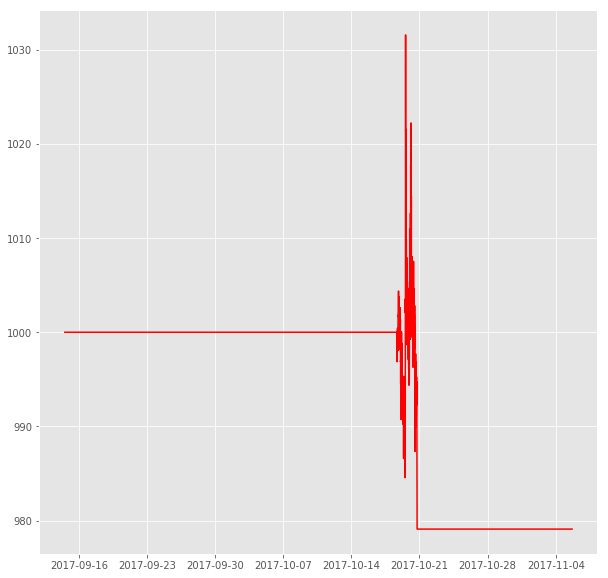

In [6]:
def plot_balance(coin, date):
    df = get_balances(date=date)
    tick = get_tickers(date = date, coin = None, screen = 0)
    merged = pd.merge(df, tick, how='left', left_on=['coin', 'date'], right_on=['coin', 'date'])
    merged.loc[merged['coin'] == 'USD', 'price'] = 1
    merged['value'] = merged['size_position'] * merged['price']
    df = merged.groupby(['date'])['value'].sum().reset_index()
    print(round((df.iloc[::-1].iloc[0].value/df.iloc[0].value),4)*100)
    fig, ax = plt.subplots()
    ax.plot(df.date.values, df.value, color = 'red')
#     plt.ylim(0, 2000)
    plt.show()
    
plot_balance('USD', '2018-03-11 18:25:00')

In [7]:
def get_signs(df):
    
    df.loc[df['dif_current'] <= -0.05, 'dif_sign_c'] = 0
    df.loc[df['dif_current'] >= 0.03, 'dif_sign_c'] = 1
    df.loc[(df['dif_current'] < 0.03) & (df['dif_current'] > -0.05), 'dif_sign_c'] = 2

    df.loc[df['dif_base'] <= -0.05, 'dif_sign_b'] = 0
    df.loc[df['dif_base'] >= 0.03, 'dif_sign_b'] = 1
    df.loc[(df['dif_base'] < 0.03) & (df['dif_base'] > -0.05), 'dif_sign_b'] = 2

    df.loc[df['d_dif'] <= -0.17, 'd_dif_sign'] = 0
    df.loc[df['d_dif'] >= 0.13, 'd_dif_sign'] = 1
    df.loc[(df['d_dif'] < 0.13) & (df['d_dif'] > -0.17), 'd_dif_sign'] = 2

    df.loc[df['theta_base'] <= -0.06, 'theta_sign_b'] = 0
    df.loc[df['theta_base'] >= 0.04, 'theta_sign_b'] = 1
    df.loc[(df['theta_base'] < 0.04) & (df['theta_base'] > -0.06), 'theta_sign_b'] = 2
    
    df.loc[df['theta_current'] <= -0.06, 'theta_sign_c'] = 0
    df.loc[df['theta_current'] >= 0.04, 'theta_sign_c'] = 1
    df.loc[(df['theta_current'] < 0.04) & (df['theta_current'] > -0.06), 'theta_sign_c'] = 2

    df.loc[df['d_theta'] <= -0.3, 'd_theta_sign'] = 0
    df.loc[df['d_theta'] >= 0.3, 'd_theta_sign'] = 1
    df.loc[(df['d_theta'] < 0.3) & (df['d_theta'] > -0.3), 'd_theta_sign'] = 2
    return df

In [23]:
def get_max_growth(tickers_filtered, base_price):
    max_growth = 0
    min_growth = 0
    for i, r in tickers_filtered.iterrows():
        g = np.log(r.price/base_price)
        max_growth = g if g > max_growth else max_growth
        min_growth = g if g < min_growth else min_growth
    return max_growth, min_growth


def get_max_min(mkt_trend_df):
    tickers_df_two = get_tickers()
    tickers_df_one = get_tickers(screen=0)
    for c in tickers_df_two.coin.unique():
        tickers_df_two_c = tickers_df_two[tickers_df_two['coin'] == c]
        tickers_df_one_c = tickers_df_one[tickers_df_one['coin'] == c]
        print(c)
        for index in range(len(tickers_df_two_c)):
            base_date = tickers_df_two_c.iloc[index].date
            base_price = tickers_df_two_c.iloc[index].price
            if index >= (len(tickers_df_two_c)-2):
                break
            last_date = tickers_df_two_c.iloc[(index+2)].date
            t = tickers_df_one_c[(tickers_df_one_c['date'] >= base_date) & (tickers_df_one_c['date'] < last_date)]
            max_growth, min_growth = get_max_growth(t, base_price)
            tickers_df_two.loc[(tickers_df_two['date'] == base_date) & 
                               (tickers_df_two['coin'] == c), 'max_growth'] = max_growth
            tickers_df_two.loc[(tickers_df_two['date'] == base_date) & 
                               (tickers_df_two['coin'] == c), 'min_growth'] = min_growth
    
    tickers_df_two = tickers_df_two.dropna()
    return tickers_df_two

In [24]:
def manipulate_mkt_data():
    mkt_trend_df = get_mkt_trend()
    tickers_df_two = get_max_min(mkt_trend_df)
    macds_df = get_macds()
    tickers_df = pd.merge(tickers_df_two, macds_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    tickers_df['ema_dif'] = np.log(tickers_df['price']/tickers_df['ema12'])
    df = pd.merge(mkt_trend_df, tickers_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
#     df = get_signs(df)
#     df.loc[(1 > df['ema_dif']) & (df['ema_dif'] > -0.1), 'ema_sign'] = 1
#     df.loc[(1 <= df['ema_dif']) | (df['ema_dif'] <= -0.1), 'ema_sign'] = 0
#     rsis_df = get_rsis()
#     df = pd.merge(df, rsis_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
#     df.loc[df['rsi'] >= 70, 'signal_rsi'] = -1
#     df.loc[df['rsi'] <= 30, 'signal_rsi'] = 1
#     df.loc[(30 < df['rsi']) & (df['rsi'] < 70), 'signal_rsi'] = 0
    return df
    
df = manipulate_mkt_data()

USDT_BTC
USDT_LTC
USDT_XRP


In [46]:
f_df = df.drop(['signal_line', 'histogram', 'screen_x', 'screen_y', 'screen', 'vote', 'price', 'ema_26',
               'macd_line', 'ema12'], axis = 1)
f_df.loc[f_df['max_growth'] >= 0.1, 'growth_sign'] = 1
f_df.loc[f_df['max_growth'] < 0.1, 'growth_sign'] = 0
f_df.loc[f_df['min_growth'] <= -0.1, 'reduce_sign'] = 1
f_df.loc[f_df['min_growth'] > -0.1, 'reduce_sign'] = 0
full_data_set = f_df[['coin', 'date', 'dif_base', 'dif_current', 'd_dif', 'theta_base', 'theta_current', 'd_theta',
                      'ema_dif', 'min_growth', 'max_growth', 'reduce_sign', 'growth_sign']]
full_data_set.head()

,coin,date,dif_base,dif_current,d_dif,theta_base,theta_current,d_theta,ema_dif,min_growth,max_growth,reduce_sign,growth_sign
0,USDT_BTC,2017-09-19 01:10:00,0.033570,0.034307,0.021948,0.041643,1.117352,25.831967,0.013771,-0.035055,0.010431,0.0,0.0
1,USDT_LTC,2017-09-19 02:05:00,0.023714,0.026678,0.125005,0.007498,-0.005042,-1.672395,-0.016950,-0.036507,0.053272,0.0,0.0
2,USDT_XRP,2017-09-19 03:25:00,0.014942,0.016933,0.133223,0.000046,-0.000091,-2.995778,-0.015621,-0.007232,0.018841,0.0,0.0
3,USDT_BTC,2017-09-19 05:10:00,0.031682,0.033570,0.059607,1.117352,-1.200100,-2.074057,-0.001001,-0.000254,0.024631,0.0,0.0
4,USDT_LTC,2017-09-19 06:05:00,0.021445,0.023714,0.105776,-0.005042,-0.046591,8.241326,-0.012765,-0.003766,0.049506,0.0,0.0


In [50]:
coin_df = full_data_set[full_data_set['coin'] == 'USDT_XRP'].sort_values(['date'])
coin_df

,coin,date,dif_base,dif_current,d_dif,theta_base,theta_current,d_theta,ema_dif,min_growth,max_growth,reduce_sign,growth_sign
2,USDT_XRP,2017-09-19 03:25:00,0.014942,0.016933,0.133223,0.000046,-9.148396e-05,-2.995778,-0.015621,-0.007232,0.018841,0.0,0.0
5,USDT_XRP,2017-09-19 07:25:00,0.014425,0.014942,0.035838,-0.000091,-8.250729e-05,-0.098123,-0.004291,-0.010103,0.021313,0.0,0.0
8,USDT_XRP,2017-09-19 11:25:00,0.012668,0.014425,0.138731,-0.000083,4.632375e-05,-1.561450,-0.009164,-0.012657,0.026857,0.0,0.0
11,USDT_XRP,2017-09-19 15:25:00,0.011222,0.012668,0.128818,0.000046,-2.153417e-05,-1.464862,0.004708,-0.033456,0.005427,0.0,0.0
14,USDT_XRP,2017-09-19 19:25:00,0.009085,0.011222,0.235261,-0.000022,6.060042e-05,-3.814152,-0.013364,-0.022728,0.010270,0.0,0.0
17,USDT_XRP,2017-09-19 23:25:00,0.006667,0.009085,0.362672,0.000061,-7.829458e-05,-2.291981,-0.017112,-0.015738,0.015522,0.0,0.0
20,USDT_XRP,2017-09-20 03:25:00,0.004245,0.006667,0.570601,-0.000078,-2.685792e-05,-0.656963,-0.013305,-0.004853,0.023644,0.0,0.0
23,USDT_XRP,2017-09-20 07:25:00,0.002871,0.004245,0.478440,-0.000027,2.082292e-06,-1.077530,-0.008697,-0.006780,0.021205,0.0,0.0
26,USDT_XRP,2017-09-20 11:25:00,0.002805,0.002871,0.023534,0.000002,1.041667e-05,4.002501,0.008848,-0.027796,0.002670,0.0,0.0
29,USDT_XRP,2017-09-20 15:25:00,0.001589,0.002805,0.765737,0.000010,7.186729e-05,5.899260,0.001023,-0.038169,0.006816,0.0,0.0


In [ ]:
f_df = f_df[f_df['coin'] == 'USDT_XRP']
count_threshold = 10
win_threshold = 0.7
total = len(f_df)
resume_df = pd.DataFrame()
x_features = ['dif_sign_b', 'dif_sign_c', 'd_dif_sign', 'd_theta_sign',
              'theta_sign_b', 'theta_sign_c', 'signal_rsi']
y_features = ['growth_sign']
a = x_features.copy()
for i in range(len(x_features)+1):
    x_features = a.copy()
    if i:
        del x_features[i-1]
    linear_parms = f_df[x_features + y_features]
    winners = linear_parms[linear_parms['growth_sign'] == 1]
    winners = winners.groupby(x_features).count().reset_index()
    losers = linear_parms[linear_parms['growth_sign'] == 0]
    losers = losers.groupby(x_features).count().reset_index()
    all_ = pd.merge(winners, losers, how='left', 
                    left_on= x_features,
                    right_on= x_features)
    all_['p_win'] = all_['growth_sign_x']/ ( all_['growth_sign_x'] +  all_['growth_sign_y'])
    all_['count'] = (all_['growth_sign_x'] +  all_['growth_sign_y'])
    all_['per_total'] = all_['count']/total


    
    count_df = all_[(all_['count'] >= count_threshold) & (all_['p_win'] >= win_threshold)].\
        sort_values(by = ['p_win', 'count'], ascending = False).drop(['p_win', 'count'], axis = 1)
    count_df['total'] = count_df['growth_sign_x'] + count_df['growth_sign_y']
    count_df['per_win'] = count_df['growth_sign_x'] / count_df['total']
    count_df['alpha'] = count_df['per_total'] * count_df['per_win']
    
    resume_df = pd.concat([resume_df,count_df], axis=0, ignore_index=True)

    
resume_df.sort_values(by=['per_win', 'total','alpha','d_dif_sign', 'd_theta_sign', 'dif_sign_b', 'dif_sign_c', 'theta_sign_b', 
                         'theta_sign_c', 'signal_rsi'],
                      ascending=False)[['d_dif_sign', 'd_theta_sign', 'dif_sign_b', 'dif_sign_c', 'theta_sign_b', 
'theta_sign_c', 'signal_rsi', 'total',
                                        'per_total', 'per_win', 'alpha']]